In [113]:
from typing import TypedDict,Literal
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


In [114]:
load_dotenv()

True

In [115]:
model=ChatOpenAI(model='gpt-4o-mini')

In [116]:
class sentimentSchema(BaseModel):
    sentiment: Literal['Positive','Negative']=Field(description="Sentiment of the review")
    

In [117]:
class diagnosisSchema(BaseModel):
    issue_type: Literal['UX','Performance','Bug','Support','Other']=Field(description='The category of issue mentioned in the review')
    tone: Literal['angry','dissappointed','calm','frustrated']=Field(description='The emotional tone expressed by the user')
    urgency: Literal['low','medium','high']=Field(description='how urgent the issue is')
    

In [118]:
structured_output_model2=model.with_structured_output(diagnosisSchema)

In [119]:
structured_model=model.with_structured_output(sentimentSchema)



In [120]:
class reviewState(TypedDict):
    review:str
    sentiment:Literal["positive","Negative"]
    diagnosis:dict
    response:str

In [121]:
graph=StateGraph(reviewState)


In [122]:
def Find_sentiment(state: reviewState):
    prompt=f' Fint the sentiment of the following sentence {state['review']}'
    sentiment=structured_model.invoke(prompt).sentiment
    return {'sentiment':sentiment}

def check_sentiment(state:reviewState)->Literal['run_diagnosis','positve_response']:
    senti=state['sentiment']
    if senti=='Positive':
        return 'positve_response'
    else:
        return 'run_diagnosis'

def positve_response(state:reviewState):
    response=f"Thank you for your valuable feedback we are happy that you liked our product"
    return {'response':response}


def run_diagnosis(state:reviewState):
    prompt=f""" Diagnosis this negative review {state['review']} and etract the issue type, tone and urgency"""
    response= structured_output_model2.invoke(prompt)
    return {'diagnosis':response.model_dump()}

def negative_response(state:reviewState):
    prompt=f"Provide a sorry message to the user's review {state['review']} with his negative experince with the product, conside the {state['diagnosis']} while asking sorry"
    repsonse=model.invoke(prompt).content
    return {'response':repsonse}




In [123]:
graph.add_node('Find_sentiment',Find_sentiment)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('positve_response',positve_response)
graph.add_node('negative_response',negative_response)

In [124]:
graph.add_edge(START,'Find_sentiment')
graph.add_conditional_edges('Find_sentiment',check_sentiment)
graph.add_edge('positve_response',END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)

workflow=graph.compile()


In [127]:
initial_state={'review':"This product system is not that good"}
workflow.invoke(initial_state)

{'review': 'This product system is not that good',
 'sentiment': 'Negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'dissappointed',
  'urgency': 'medium'},
 'response': "Dear [User's Name],\n\nWe sincerely apologize for your disappointing experience with our product. We understand that performance issues can be incredibly frustrating, and we appreciate you taking the time to share your feedback.\n\nYour satisfaction is important to us, and we are committed to addressing the concerns you've raised. We would love to learn more about your specific experience so that we can work towards a solution.\n\nPlease reach out to our support team at [support contact information], and we will do our best to assist you promptly.\n\nThank you for your understanding, and again, we are truly sorry for the inconvenience.\n\nBest regards,  \n[Your Company Name] Team"}

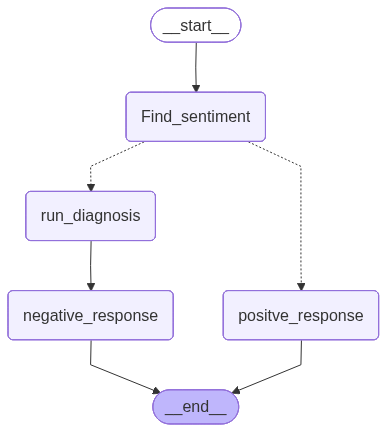

In [83]:
graph.compile()